In [1]:
from xgboost import XGBRegressor as XGBR 
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
from time import time
import datetime

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [3]:
x = data
y = target
x.shape, y.shape

((506, 13), (506,))

In [4]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=888)

# 梯度提升树

In [5]:
xgb = XGBR(n_estimators = 100).fit(xtrain, ytrain)
y_pred = xgb.predict(xtest)

In [6]:
xgb.score(xtest, ytest)
# R^2

0.8198447083487521

In [7]:
MSE(ytest, y_pred), y.mean()

(13.17420745083781, 22.532806324110677)

In [8]:
xgb.feature_importances_
# 这是树模型的一个优势，我们可以查看模型的重要性分数。可以用嵌入法进行特征选择

array([0.02634421, 0.00309393, 0.01594052, 0.00801771, 0.01708667,
       0.44775116, 0.01217775, 0.1023967 , 0.02675674, 0.05623093,
       0.02783497, 0.0057254 , 0.2506433 ], dtype=float32)

In [9]:
import sklearn
sorted(sklearn.metrics.get_scorer_names())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'd2_absolute_error_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_max_error',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 're

### 参数n_estimators

In [10]:
# 交叉验证
xgb = XGBR(n_estimators = 100)
cross_val_score(xgb, xtrain, ytrain, cv = 10).mean()
# 回归模型交叉验证返回的是R^2
# 分类模型交叉验证返回的是Accuracy

0.8407881556828635

In [11]:
cross_val_score(xgb, xtrain, ytrain, scoring='neg_mean_squared_error', cv = 10).mean()

-14.418184622751047

In [12]:
# 使用RFR和LR进行对比
rfr = RFR(n_estimators=100)
cross_val_score(rfr, xtrain, ytrain, cv = 10).mean()

0.8462903549280056

In [13]:
cross_val_score(rfr, xtrain, ytrain, cv = 10, scoring='neg_mean_squared_error').mean()

-14.62110937674603

In [14]:
lr = LR()
cross_val_score(lr, xtrain, ytrain, cv = 10).mean()

0.7117751325539305

In [15]:
cross_val_score(lr, xtrain, ytrain, cv = 10, scoring='neg_mean_squared_error').mean()

-25.612033004532528

两个集成算法差不多
线性回归差一点

#### xgb不同样本数量下的学习曲线

In [16]:
def plot_leanring_curve(estimator, title, x, y
                        , ax = None # 选择子图
                        , ylim = None # 设置纵坐标取值范围
                        , cv = None
                        , n_jobs = None # 线程
                        ):
    from sklearn.model_selection import learning_curve
    import  matplotlib.pyplot as plt
    import numpy as np

    train_sizes, train_scores, test_scores = learning_curve(estimator, x, y
                                                            , shuffle= True
                                                            , cv = cv
                                                            , random_state=420
                                                            , n_jobs=n_jobs
                                                            )
    
    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()

    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel('Training Samples')
    ax.set_ylabel('Score')
    ax.grid()
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label = 'Training score')
    ax.plot(train_sizes, np.mean(test_scores, axis = 1), 'o-', label = 'Test acore')
    ax.legend()
    return ax

<Axes: title={'center': 'XGBoost'}, xlabel='Training Samples', ylabel='Score'>

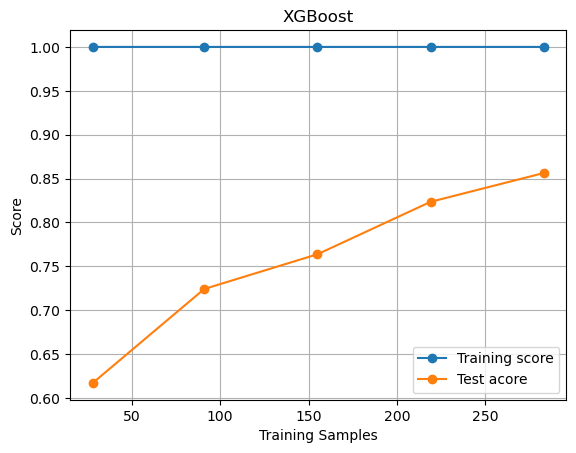

In [17]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle= True, random_state=888)
plot_leanring_curve(XGBR(n_estimators = 100, random_state = 888)
                    , 'XGBoost'
                    , xtrain, ytrain
                    , ax = None
                    , cv = cv)

# 下图看出来：过拟合

#### 调整n_estimators

60 0.8409129267723502


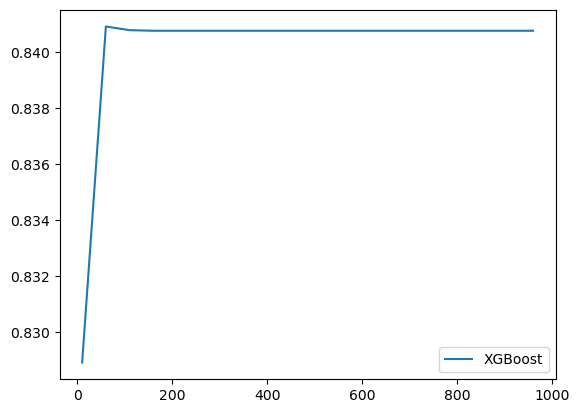

In [18]:
axisx = range(10, 1010, 50)
score = []
for i in axisx:
    xgb = XGBR(n_estimators = i, random_state = 888)
    score.append(cross_val_score(xgb, xtrain, ytrain, cv = 10).mean())

print(axisx[score.index(max(score))], max(score))
plt.figure()
plt.plot(axisx, score, label = 'XGBoost')
plt.legend()
plt.show()


#### Bias-Vars Tradeoff

数据集过少，模型不太稳定

In [19]:
axisx = range(10, 1010, 50)
score, var, ge = [], [], []
for i in axisx:
    xgb = XGBR(n_estimators = i, random_state = 888)
    cvresult = cross_val_score(xgb, xtrain, ytrain, cv = 10)
    # mean = 1 - bias
    score.append(cvresult.mean())
    var.append(cvresult.var())
    # 泛化误差的可控部分
    ge.append((1 - cvresult.mean())**2 + cvresult.var())


max(score): 60 0.8409129267723502 0.008890644247462302
min(Var): 60 0.008890644247462302 0.8409129267723502
min(bias^2 + var): 60 0.03419934111560192 0.008890644247462302 0.8409129267723502


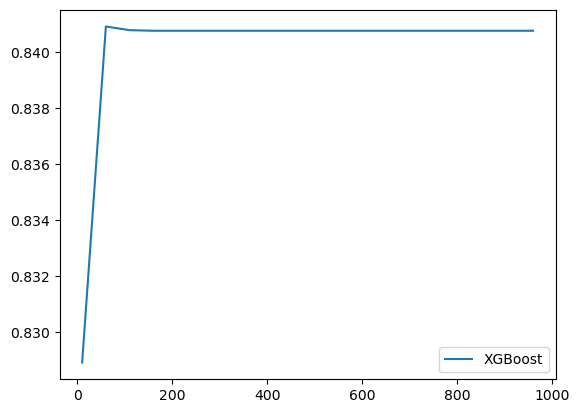

In [20]:

print('max(score):', axisx[score.index(max(score))], max(score), var[score.index(max(score))])
print('min(Var):', axisx[var.index(min(var))], min(var), score[var.index(min(var))])
print('min(bias^2 + var):', axisx[ge.index(min(ge))], min(ge), var[ge.index(min(ge))], score[ge.index(min(ge))])

plt.figure()
plt.plot(axisx, score, label = 'XGBoost')
plt.legend()
plt.show()


In [21]:
axisx = range(10, 210, 10)
score, var, ge = [], [], []
for i in axisx:
    xgb = XGBR(n_estimators = i, random_state = 888)
    cvresult = cross_val_score(xgb, xtrain, ytrain, cv = 10)
    # mean = 1 - bias
    score.append(cvresult.mean())
    var.append(cvresult.var())
    # 泛化误差的可控部分
    ge.append((1 - cvresult.mean())**2 + cvresult.var())

max(score): 60 0.8409129267723502 0.008890644247462302
min(Var): 50 0.008881107679696593 0.8408306737101775
min(bias^2 + var): 60 0.03419934111560192 0.008890644247462302 0.8409129267723502


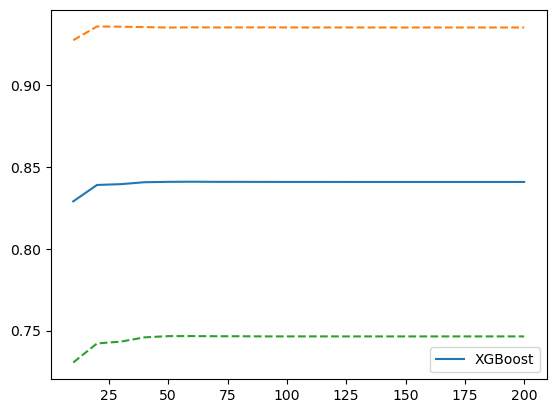

In [22]:
print('max(score):', axisx[score.index(max(score))], max(score), var[score.index(max(score))])
print('min(Var):', axisx[var.index(min(var))], min(var), score[var.index(min(var))])
print('min(bias^2 + var):', axisx[ge.index(min(ge))], min(ge), var[ge.index(min(ge))], score[ge.index(min(ge))])

plt.figure()
plt.plot(axisx, score, label = 'XGBoost')
plt.plot(axisx, score+np.sqrt(var), '--')
plt.plot(axisx, score-np.sqrt(var), '--')
plt.legend()
plt.show()

In [23]:
time0 = time()
print(XGBR(n_estimators = 100, random_state = 888).fit(xtrain, ytrain).score(xtest, ytest))
print(time() - time0)

0.8198447083487521
0.23227262496948242


In [24]:
time0 = time()
print(XGBR(n_estimators = 50, random_state = 888).fit(xtrain, ytrain).score(xtest, ytest))
print(time() - time0)

0.8192491340479021
0.16395306587219238


In [25]:
time0 = time()
print(XGBR(n_estimators = 60, random_state = 888).fit(xtrain, ytrain).score(xtest, ytest))
print(time() - time0)

0.8197959081256804
0.1518394947052002


在训练集上的表现，还是我们一开始选择的100的效果最好

#### 评价

首先，XGB中的树的数量决定了模型的学习能力，树的数量越多，模型的学习能力越强。只要XGB中树足够多，即便只有很少的数据，模型也能够学到训练数据100%的信息，所以XGB也是天生过拟合的模型。但是这种情况下， 模型会变得非常不稳定。

第二，XGB中树的数量很少的时候，对模型的影响较大，当树的数量已经很多的时候，对模型的影响比较小，只能有微弱的变化。当数据本身就处于过拟合的时候，再使用过多的树能达到的效果甚微，反而浪费计算资源。当唯一指标R“或者准确率给出的n_estimators看起来不太可靠的时候，我们可以改造学习曲线来帮助我们。

第三，树的数量提升对模型的影响有极限，最开始，模型的表现会随着XGB的树的数量一起提升，但到达某个点之后，树的数量越多，模型的效果会逐步下降，这也说明了暴力增加n_estimators不一定有效果。

这些都和随机森林中的参数n_estimators表现出一致的状态。在随机森林中我们总是先调整n_estimators，当n_estimators的极限已达到，我们才考虑其他参数，但XGB中的状况明显更加复杂，当数据集不太寻常的时候会更加复杂。这是我们要给出的第一个超参数，因此还是建议优先调整n_estimators，一般都不会建议一个太大的数目，300以下为佳。

### 参数silent

监控模型的训练速度

In [49]:
xgb = XGBR(n_estimators = 10, silent = False)

In [50]:
cross_val_score(xgb, xtrain, ytrain, cv = 10).mean()

d:\anaconda\envs\mineenv\lib\site-packages\xgboost\training.py:183: UserWarning: [22:46:58] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\anaconda\envs\mineenv\lib\site-packages\xgboost\training.py:183: UserWarning: [22:46:58] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\anaconda\envs\mineenv\lib\site-packages\xgboost\training.py:183: UserWarning: [22:46:58] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\anaconda\envs\mineenv\lib\site-packages\xgboost\training.py:183: UserWarning: [22:46:58] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "silent" }

0.8289151386384276

### 参数subsample

范围[0, 1]，抽样的比例

有放回随机抽样

让模型更加集中于容易被判错的样本

通常是在样本量本身很大的时候来使用。因为有放回抽样某种程度上来说相当于减少了样本数量，样本数量越少，模型越容易过拟合。

max(score): 0.5789473684210527 0.8565415296790266
min(var): 0.6842105263157894 0.8535902251988048
min(bias^2+var): 0.5789473684210527 0.8565415296790266


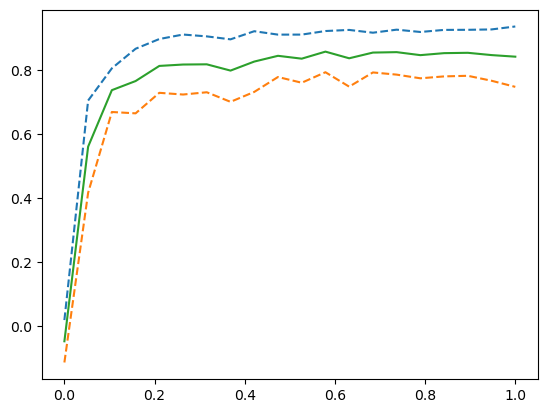

In [28]:
axisx = np.linspace(0, 1, 20)
score, var, ge = [], [], []
for i in axisx:
    xgb = XGBR(n_estimators = 100, subsample = i, random_state = 888)
    cvresult = cross_val_score(xgb, xtrain, ytrain, cv = 10)
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2 + cvresult.var())
    score.append(cross_val_score(xgb, xtrain, ytrain, cv = 10).mean())


print('max(score):', axisx[score.index(max(score))], max(score))
print('min(var):', axisx[var.index(min(var))], score[var.index(min(var))])
print('min(bias^2+var):', axisx[ge.index(min(ge))], score[ge.index(min(ge))])
plt.plot(axisx, score+np.sqrt(var), '--')
plt.plot(axisx, score-np.sqrt(var), '--')
plt.plot(axisx, score)
plt.show()

max(score): 0.6 0.8664561719143233
min(var): 0.6 0.8664561719143233
min(bias^2+var): 0.6 0.8664561719143233


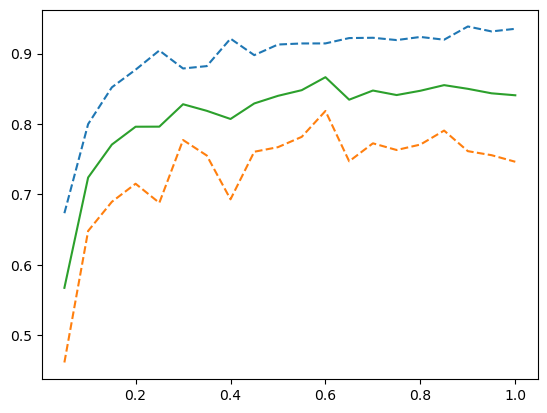

In [29]:
axisx = np.linspace(0.05, 1, 20)
score, var, ge = [], [], []
for i in axisx:
    xgb = XGBR(n_estimators = 100, subsample = i, random_state = 888)
    cvresult = cross_val_score(xgb, xtrain, ytrain, cv = 10)
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2 + cvresult.var())
    score.append(cross_val_score(xgb, xtrain, ytrain, cv = 10).mean())


print('max(score):', axisx[score.index(max(score))], max(score))
print('min(var):', axisx[var.index(min(var))], score[var.index(min(var))])
print('min(bias^2+var):', axisx[ge.index(min(ge))], score[ge.index(min(ge))])
plt.plot(axisx, score+np.sqrt(var), '--')
plt.plot(axisx, score-np.sqrt(var), '--')
plt.plot(axisx, score)
plt.show()

In [30]:
xgb = XGBR(n_estimators = 100, random_state = 888, subsample = 0.6).fit(xtrain, ytrain)
xgb.score(xtest, ytest)

0.8509379800998722

In [31]:
MSE(ytest, xgb.predict(xtest))

10.9004512451777

### 参数eta

学习率$\eta$，新添加的树的权重

越大，迭代速度越快，有可能无法收敛到真正的最佳

越小，越有可能找到精确的最佳值，但迭代速度会比较缓慢。

In [32]:
def regassess(xgb, xtrain, ytrain, cv, scoring = ['r2'], show = True):
    score = []
    for i in range(len(scoring)):
        if show:
            print('{}:{:.5f}'.format(scoring[i]
                                    , cross_val_score(xgb, xtrain, ytrain, cv = cv, scoring=scoring[i]).mean()))
        score.append(cross_val_score(xgb, xtrain, ytrain, cv = cv, scoring=scoring[i]).mean())
           
    return score

In [33]:
xgb = XGBR(n_estimators = 100, random_state = 888, subsample = 0.6)

regassess(xgb, xtrain, ytrain, cv = 10, scoring=['r2', 'neg_mean_squared_error'])

r2:0.86646
neg_mean_squared_error:-11.49479


[0.8664561719143233, -11.494785740308]

In [34]:
for i in [0, 0.2, 0.3, 0.5, 1]:
    time0 = time()
    xgb = XGBR(n_estimators = 100, random_state = 888, learning_rate = i, subsample = 0.6)
    print('leaning_reta = {}'.format(i))
    regassess(xgb, xtrain, ytrain, cv = 10, scoring=['r2', 'neg_mean_squared_error'])
    print(datetime.datetime.fromtimestamp(time() - time0).strftime('%M:%S:%f'))
    print('\t')

leaning_reta = 0
r2:-0.04857
neg_mean_squared_error:-89.54694
00:06:936915
	
leaning_reta = 0.2
r2:0.86202
neg_mean_squared_error:-12.50624
00:06:906297
	
leaning_reta = 0.3
r2:0.86646
neg_mean_squared_error:-11.49479
00:06:504032
	
leaning_reta = 0.5
r2:0.83258
neg_mean_squared_error:-14.16540
00:06:126024
	
leaning_reta = 1
r2:0.65625
neg_mean_squared_error:-29.28588
00:05:694960
	


In [35]:
axisx = np.arange(0.05, 1, 0.05)
score, test = [], []
for i in axisx:
    xgb = XGBR(n_estimators = 100, random_state = 888, subsample = 0.6, learning_rate = i)
    scorel = (regassess(xgb, xtrain, ytrain, cv = 10, scoring = ['r2', 'neg_mean_squared_error'], show=False))
    score.append(scorel[0])
    test.append(xgb.fit(xtrain, ytrain).score(xtest, ytest))


0.25 0.866506855875261 test score: 0.8592890628349033
0.1 0.8869682355991315


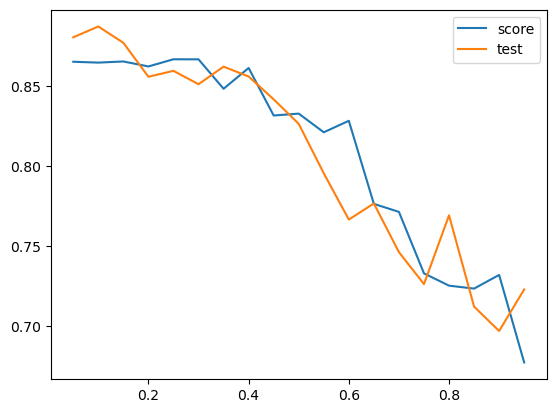

In [36]:

print(axisx[score.index(max(score))], max(score), 'test score:', test[score.index(max(score))])
print(axisx[test.index(max(test))], max(test))
plt.figure()
plt.plot(axisx, score, label = 'score')
plt.plot(axisx, test, label = 'test')
plt.legend()
plt.show()

通常来说，我们不调整$\eta$

如果我们希望模型的效果更好，更多的是从树本身来说，对树进行剪枝

# XGBoost

### 参数booster

| xgb.train() & params | xgb.XGBRegressor() |
|---|---|
| xgb_model | booster |
| 使用哪种弱评估器。可以输入gbtree, gblinear或dart。输入的评估器不同，使用的params参数也不同，每种评估器都有自己的params列表。评估器必须于param参数相匹配，否则报错。 | 使用哪种弱评估器。可以输入gbtree, gblinear或dart。gbtree代表梯度提升树，dart是Dropouts meet Multiple Additive Regression Trees, 可译为抛弃提升树，在建模的过程中会抛弃一部分树，比梯度提升树有更好的防过拟合功能。输入gblinear使用线性模型。 |

In [5]:
for booster in ['gbtree', 'gblinear', 'dart']:
    xgb = XGBR(n_estimators = 100
               , learning_rate = 0.1
               , random_state = 888
               , booster = booster
               , subsample = 0.6).fit(xtrain, ytrain)
    print(booster)
    print(xgb.score(xtest, ytest))

gbtree
0.8869682355991315
gblinear
0.6150362407763524


d:\anaconda\envs\mineenv\lib\site-packages\xgboost\training.py:183: UserWarning: [16:55:39] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


dart
0.8599549140023726


### 目标函数Obj

```mermaid
graph LR
    A[读取数据] --> B[设置参数];
    B --> C[训练模型];
    C --> D[预测结果];
    A["xgb.DMatrix()"]
    B["param = {}"]
    C["bst = xgb.train(param)"]
    D["bst.predict()"]
```




| xgb.train() | xgb.XGBRegressor() | xgb.XGBClassifier() |
|---|---|---|
| obj: 默认binary:logistic | **objective**: 默认reg:linear | objective: 默认binary:logistic |

常用的选择有：

| 输入 | 选用的损失函数 |
|---|---|
| reg:linear | 使用线性回归的损失函数，均方误差，回归时使用 |
| binary:logistic | 使用逻辑回归的损失函数，对数损失log_loss，二分类时使用 |
| binary:hinge | 使用支持向量机的损失函数，Hinge Loss，二分类时使用 |
| multi:softmax | 使用softmax损失函数，多分类时使用 |

还可以自己输入

In [6]:
# sklearn实现法
xgb = XGBR(n_estimators = 100, random_state = 999).fit(xtrain, ytrain)
xgb.score(xtest, ytest), MSE(ytest, xgb.predict(xtest))

(0.8198447083487521, 13.17420745083781)

In [7]:
# xgb实现法
import xgboost as XGB

# 使用类Dmatrix读取数据
dtrain = XGB.DMatrix(xtrain, ytrain)
dtest = XGB.DMatrix(xtest, ytest)
# 无法直接打开查看，只能先读入pd然后再放入DMatrix
dtrain.get_data()


<354x13 sparse matrix of type '<class 'numpy.float32'>'
	with 4602 stored elements in Compressed Sparse Row format>

In [8]:
pd.DataFrame(xtrain)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,9.51363,0.0,18.10,0.0,0.713,6.728,94.1,2.4961,24.0,666.0,20.2,6.68,18.71
1,15.86030,0.0,18.10,0.0,0.679,5.896,95.4,1.9096,24.0,666.0,20.2,7.68,24.39
2,0.03445,82.5,2.03,0.0,0.415,6.162,38.4,6.2700,2.0,348.0,14.7,393.77,7.43
3,0.08187,0.0,2.89,0.0,0.445,7.820,36.9,3.4952,2.0,276.0,18.0,393.53,3.57
4,0.03548,80.0,3.64,0.0,0.392,5.876,19.1,9.2203,1.0,315.0,16.4,395.18,9.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,0.17134,0.0,10.01,0.0,0.547,5.928,88.2,2.4631,6.0,432.0,17.8,344.91,15.76
350,1.65660,0.0,19.58,0.0,0.871,6.122,97.3,1.6180,5.0,403.0,14.7,372.80,14.10
351,0.09252,30.0,4.93,0.0,0.428,6.606,42.2,6.1899,6.0,300.0,16.6,383.78,7.37
352,0.17331,0.0,9.69,0.0,0.585,5.707,54.0,2.3817,6.0,391.0,19.2,396.90,12.01


In [ ]:
# 写明参数
param = {'silent':False
         , 'objective':'reg:squarederror'
         , 'eta':0.1}
num_round = 100


In [10]:

# 类train，可以直接导入的参数是训练数据，树的数量
# 其他参数都需要params来导入
bst = XGB.train(param, dtrain, num_round)
preds = bst.predict(dtest)


d:\anaconda\envs\mineenv\lib\site-packages\xgboost\training.py:183: UserWarning: [16:55:51] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "slient" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [11]:
from sklearn.metrics import r2_score
r2_score(ytest, preds)

0.8048260280507197

In [14]:
MSE(ytest, preds)

14.272477771240682

### 惩罚项系数与正则化参数

$\gamma$：惩罚项系数

$\alpha$：L1正则化参数

$\lambda$：L2正则化参数

#### $\alpha$ & $\lambda$

In [21]:
# 使用网格搜索来查找最佳参数组合
from sklearn.model_selection import GridSearchCV

param = {'reg_alpha':np.arange(0, 5, 0.05)
         , 'reg_lambda':np.arange(0, 2, 0.05)}

gscv = GridSearchCV(xgb, param_grid=param, scoring='neg_mean_squared_error', cv = 10)

In [ ]:
# time warning
time0 = time()
gscv.fit(xtrain, ytrain)
print(datetime.datetime.fromtimestamp(time() - time0).strftime('%M:%S:%f'))

In [ ]:
gscv.best_params_

In [ ]:
gscv.best_score_

In [ ]:
preds = gscv.predict(xtest)

#### $\gamma$

很重要

让树停止生长

$\gamma$越大，惩罚越严重，树将越保守，越不容易过拟合

In [ ]:
# 通过传统的学习曲线
axisx = np.arange(1, 5, 0.05)
score, var, ge = [], [], []
for i in axisx:
    model = XGBR(n_estimators = 100, random_state = 888, gamma = i)
    result = cross_val_score(model, xtrain, ytrain, cv = 10)
    score.append(result.mean())
    var.append(result.var())
    ge.append((1 - result.mean())**2 + result.var())


max(score): 2.950000000000002 0.8491807482358608
min(var): 2.950000000000002 0.8491807482358608
min(ge): 2.950000000000002 0.8491807482358608


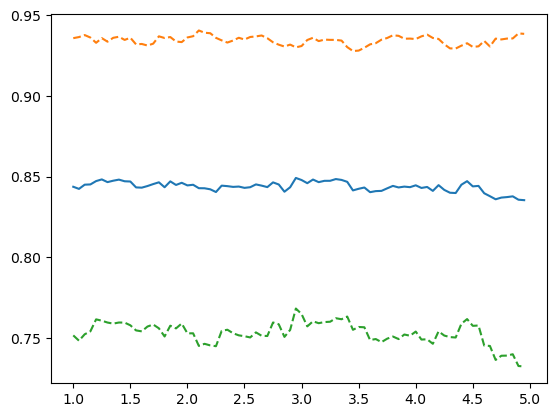

In [16]:


print('max(score):', axisx[score.index(max(score))], max(score))
print('min(var):', axisx[var.index(min(var))], score[var.index(min(var))])
print('min(ge):', axisx[ge.index(min(ge))], score[ge.index(min(ge))])

plt.figure()
plt.plot(axisx, score)
plt.plot(axisx, score + np.sqrt(var), '--')
plt.plot(axisx, score - np.sqrt(var), '--')

plt.show()

完全无法看出趋势，$\gamma$引起的波动远远超过其他的参数的改变，无法贸然取值

引入xgboost库中的类xgboost.cv

### xgboost.cv

常用指标
| 指标 | 含义 |
|---|---|
| rmse | 回归用，调整后的均方误差 |
| mae | 回归用，绝对平均误差 |
| logloss | 二分类用，对数损失 |
| mlogloss | 多分类用，对数损失 |
| error | 分类用，分类误差，等于1-准确率 |
| auc | 分类用，AUC面积 |

In [26]:
param1 = {'silent':True
         , 'objective':'reg:squarederror'
         , 'gamma':0}
num_round = 100
n_fold = 5

time0 = time()
cvresult1 = XGB.cv(param1, dtrain, num_round, n_fold)
print(datetime.datetime.fromtimestamp(time() - time0).strftime('%M:%S:%f'))

d:\anaconda\envs\mineenv\lib\site-packages\xgboost\training.py:215: UserWarning: [19:40:28] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


00:00:597733


In [27]:
cvresult1

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,7.029977,0.095130,7.643617,0.481202
1,5.328434,0.062754,6.290009,0.436051
2,4.103719,0.060085,5.460049,0.589032
3,3.219513,0.067879,4.875964,0.635531
4,2.551082,0.062724,4.458590,0.614815
...,...,...,...,...
95,0.006406,0.001872,3.677413,0.592420
96,0.006067,0.001747,3.677477,0.592450
97,0.005696,0.001550,3.677476,0.592469
98,0.005405,0.001398,3.677463,0.592468


<function matplotlib.pyplot.show(close=None, block=None)>

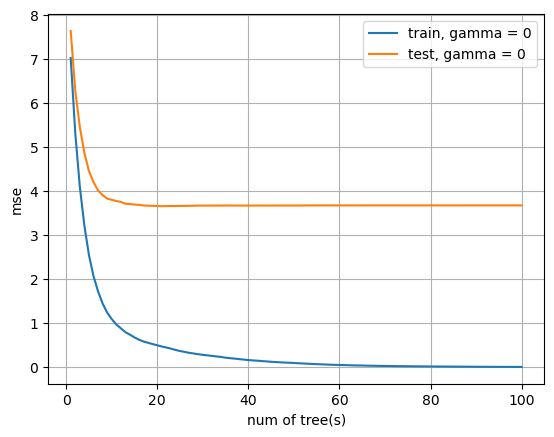

In [28]:
plt.figure()
plt.grid()
plt.plot(range(1, 101), cvresult1.iloc[:, 0], label = 'train, gamma = 0')
plt.plot(range(1, 101), cvresult1.iloc[:, 2], label = 'test, gamma = 0')
plt.legend()
plt.xlabel('num of tree(s)')
plt.ylabel('mse')
plt.show

d:\anaconda\envs\mineenv\lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `nfold` as keyword args.
  warnings.warn(msg, FutureWarning)
d:\anaconda\envs\mineenv\lib\site-packages\xgboost\training.py:215: UserWarning: [19:40:40] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


00:00:552486


<function matplotlib.pyplot.show(close=None, block=None)>

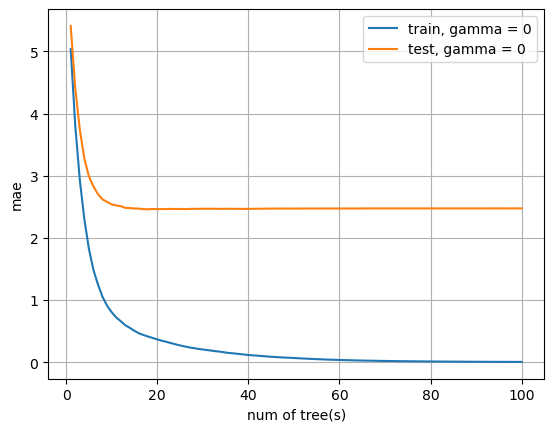

In [29]:
# 修改指标
param1 = {'silent':True
         , 'objective':'reg:squarederror'
         , 'gamma':0
         , 'eval_metric':'mae'}
num_round = 100
n_fold = 5

time0 = time()
cvresult1 = XGB.cv(param1, dtrain, num_round, n_fold)
print(datetime.datetime.fromtimestamp(time() - time0).strftime('%M:%S:%f'))
plt.figure()
plt.grid()
plt.plot(range(1, 101), cvresult1.iloc[:, 0], label = 'train, gamma = 0')
plt.plot(range(1, 101), cvresult1.iloc[:, 2], label = 'test, gamma = 0')
plt.legend()
plt.xlabel('num of tree(s)')
plt.ylabel('mae')
plt.show

过拟合

可以增大训练集的mse，或者减少测试集的mse，以使两条线接近，减弱过拟合，增强模型泛化能力。

d:\anaconda\envs\mineenv\lib\site-packages\xgboost\training.py:215: UserWarning: [19:49:22] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


00:00:612223


d:\anaconda\envs\mineenv\lib\site-packages\xgboost\training.py:215: UserWarning: [19:49:23] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


00:00:304118


<function matplotlib.pyplot.show(close=None, block=None)>

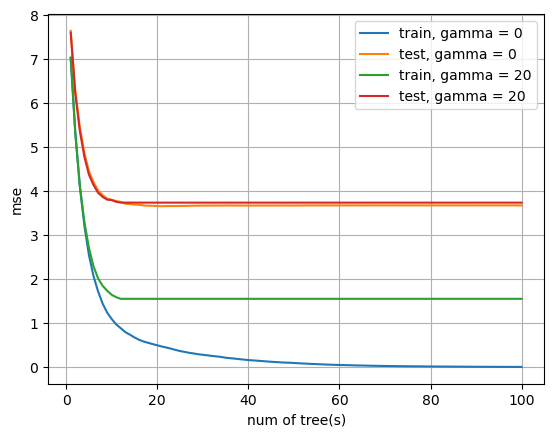

In [31]:
param1 = {'silent':True
         , 'objective':'reg:squarederror'
         , 'gamma':0
        }
param2 = {'silent':True
         , 'objective':'reg:squarederror'
         , 'gamma':20
        }
num_round = 100
n_fold = 5

time0 = time()
cvresult1 = XGB.cv(param1, dtrain, num_round, n_fold)
print(datetime.datetime.fromtimestamp(time() - time0).strftime('%M:%S:%f'))
time0 = time()
cvresult2 = XGB.cv(param2, dtrain, num_round, n_fold)
print(datetime.datetime.fromtimestamp(time() - time0).strftime('%M:%S:%f'))
plt.figure()
plt.grid()
plt.plot(range(1, 101), cvresult1.iloc[:, 0], label = 'train, gamma = 0')
plt.plot(range(1, 101), cvresult1.iloc[:, 2], label = 'test, gamma = 0')
plt.plot(range(1, 101), cvresult2.iloc[:, 0], label = 'train, gamma = 20')
plt.plot(range(1, 101), cvresult2.iloc[:, 2], label = 'test, gamma = 20')
plt.legend()
plt.xlabel('num of tree(s)')
plt.ylabel('mse')
plt.show

发现增大gamma，则两条曲线更加接近

但是测试集上的表现几乎一样

gamma是通过降低训练集上的表现来控制过拟合

#### 在分类问题上的表现

In [32]:
from sklearn.datasets import load_breast_cancer

In [34]:
data2 = load_breast_cancer()
x2 = data2.data
y2 = data2.target

xtrain2, xtest2, ytrain2, ytest2  = train_test_split(x2, y2, test_size=0.3, random_state=888) 

In [35]:
dtrain2 = XGB.DMatrix(xtrain2, ytrain2)
dtest2 = XGB.DMatrix(xtest2, ytest2)

In [36]:
param1 = {'silent':True
          , 'objective':'binary:logistic'
          , 'gamma':0
          , 'nfold':5}
param2 = {'silent':True
          , 'objective':'binary:logistic'
          , 'gamma':2
          , 'nfold':5}
num_round = 100

In [37]:
time0 = time()
cvresult1 = XGB.cv(param1, dtrain2, num_round)
print(datetime.datetime.fromtimestamp(time() - time0).strftime('%M:%S:%f'))
cvresult2 = XGB.cv(param2, dtrain2, num_round)
print(datetime.datetime.fromtimestamp(time() - time0).strftime('%M:%S:%f'))

d:\anaconda\envs\mineenv\lib\site-packages\xgboost\training.py:215: UserWarning: [20:13:42] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "nfold", "silent" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


00:00:280449
00:00:425651


In [38]:
cvresult1

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.449080,0.002957,0.470849,0.018537
1,0.325995,0.003704,0.365670,0.016136
2,0.245150,0.004736,0.296202,0.023000
3,0.188785,0.003093,0.249085,0.023419
4,0.148254,0.002929,0.218039,0.023191
...,...,...,...,...
95,0.008230,0.000125,0.122580,0.027789
96,0.008230,0.000125,0.122581,0.027789
97,0.008230,0.000125,0.122581,0.027789
98,0.008230,0.000125,0.122581,0.027789


<function matplotlib.pyplot.show(close=None, block=None)>

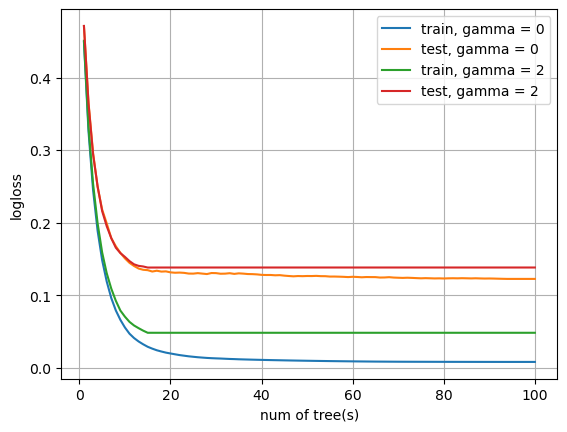

In [41]:
plt.figure()
plt.grid()
plt.plot(range(1, 101), cvresult1.iloc[:, 0], label = 'train, gamma = 0')
plt.plot(range(1, 101), cvresult1.iloc[:, 2], label = 'test, gamma = 0')
plt.plot(range(1, 101), cvresult2.iloc[:, 0], label = 'train, gamma = 2')
plt.plot(range(1, 101), cvresult2.iloc[:, 2], label = 'test, gamma = 2')
plt.legend()
plt.xlabel('num of tree(s)')
plt.ylabel('logloss')
plt.show

发现模型在测试集上的表现也下降了，说明gamma取得过大了